# Study of Image classification with modern MLP Mixer model and CKA

**Author:** [Arturo Flores](https://www.linkedin.com/in/afloresalv/)<br>
**Based on (MLP-MIXER):**  https://keras.io/examples/vision/mlp_image_classification/

# Setup for the MLP-Mixer Architecture

################################################################

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt 
from scipy.stats import norm
from matplotlib.ticker import FormatStrFormatter
import datetime
import pickle
# Files imported from the sleected GitHub https://cka-similarity.github.io/
from CKA_Google import *
import seaborn as sns 
import random
import matplotlib.pyplot as plt 

D:\Program_Files\Anaconda3\envs\AI\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


# Experiment 1 : Understand Network Architecture

## Configure the hyperparameters

In [2]:
weight_decay = 0.0001
batch_size = 512 
num_epochs = 50
dropout_rate = 0.2
learning_rate = 0.005

## Selected Architecture: B/32

image_size = 224  # We'll resize input images to this size. Square
patch_size = 32  # Size of the patches to be extracted from the input images. Square
num_patches = (image_size // patch_size) ** 2  # Size of the data array, or sequence length (S)
embedding_dim = [384]  # Fixed Embedding Dimension
num_blocks = [8,12,24,32]

print(f"Image size: {image_size} X {image_size} = {image_size ** 2}")
print(f"Patch size: {patch_size} X {patch_size} = {patch_size ** 2} ")
print(f"Patches per image: {num_patches}")
print(f"Elements per patch (3 channels): {(patch_size ** 2) * 3}")

now = datetime.datetime.now()
date = now.strftime("%Y-%m-%d_%H-%M")


Image size: 224 X 224 = 50176
Patch size: 32 X 32 = 1024 
Patches per image: 49
Elements per patch (3 channels): 3072


## Prepare the data

In [3]:
#Dataset for training 

num_classes = 10
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")
#plt.imshow(x_train[1])

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


## Build a classification model

In [4]:
def build_classifier(blocks, embedding_dim, positional_encoding=False):
    inputs = layers.Input(shape=input_shape)
    # Augment data. 
    augmented = data_augmentation(inputs)
    # Create patches. 
    patches = Patches(patch_size, num_patches)(augmented)
    # Encode patches to generate a [batch_size, num_patches, embedding_dim] tensor.
    x = layers.Dense(units=embedding_dim)(patches)
    if positional_encoding:
        positions = tf.range(start=0, limit=num_patches, delta=1)
        position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=embedding_dim
        )(positions)
        x = x + position_embedding
    # Process x using the module blocks. ## (sequential_82)
    x = blocks(x)
    # Apply global average pooling to generate a [batch_size, embedding_dim] representation tensor. 
    representation = layers.GlobalAveragePooling1D()(x)
    # Apply dropout.
    representation = layers.Dropout(rate=dropout_rate)(representation)
    # Compute logits outputs.
    logits = layers.Dense(num_classes)(representation) 
    # Create the Keras model.
    return keras.Model(inputs=inputs, outputs=logits)


## Define an experiment

In [5]:
def run_experiment(model):
    # Create Adam optimizer with weight decay. Regularization that penalizes the increase of weight - with a facto alpha - to correct the overfitting
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay,
    )
    # Compile the model.
    model.compile(
        optimizer=optimizer,
        #Negative Log Likelihood = Categorical Cross Entropy
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="acc"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top5-acc"),
        ],
    )
    # Create a learning rate scheduler callback.
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=5
    )
    # Create an early stopping regularization callback. 
    # It ends at a point that corresponds to a minimum of the L2-regularized objective
    #early_stopping = tf.keras.callbacks.EarlyStopping(
    #    monitor="val_loss", patience=10, restore_best_weights=True
    #)
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[reduce_lr],
    )

    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    # Return history to plot learning curves.
    return history, accuracy, top_5_accuracy

## Use data augmentation
Their state is not set during training; it must be set before training, either by initializing them from a precomputed constant, or by "adapting" them on data.

In [6]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)


## Implement patch extraction as a layer

In [7]:

class Patches(layers.Layer):
    def __init__(self, patch_size, num_patches):
        super(Patches, self).__init__()
        self.patch_size = patch_size
        self.num_patches = num_patches

    def call(self, images):
        #Extract the shape dimension in the position 0 = columns
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            #Without overlapping, stride horizontally and vertically
            strides=[1, self.patch_size, self.patch_size, 1],
            #Rate: Dilation factor [1 1* 1* 1] controls the spacing between the kernel points.
            rates=[1, 1, 1, 1],
            #Patches contained in the images are considered, no zero padding
            padding="VALID",
        )
        #shape[-1], number of colummns, as well as shape[0]
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, self.num_patches, patch_dims])
        return patches

    def get_config(self):
        config = super(Patches, self).get_config().copy()
        config.update ({
            'patch_size' : self.patch_size ,
            'num_patches' : self.num_patches
        })
        return config

## The MLP-Mixer model

The MLP-Mixer is an architecture based exclusively on
multi-layer perceptrons (MLPs), that contains two types of MLP layers:

1. One applied independently to image patches, which mixes the per-location features.
2. The other applied across patches (along channels), which mixes spatial information.

This is similar to a [depthwise separable convolution based model](https://arxiv.org/pdf/1610.02357.pdf)
such as the Xception model, but with two chained dense transforms, no max pooling, and layer normalization
instead of batch normalization.

### Implement the MLP-Mixer module

In [8]:

class MLPMixerLayer(layers.Layer):
    def __init__(self, num_patches, embedding_dim, dropout_rate, *args, **kwargs):
        super(MLPMixerLayer, self).__init__(*args, **kwargs)

        self.mlp1 = keras.Sequential(
            [
                layers.Dense(units=num_patches),
                tfa.layers.GELU(),
                layers.Dense(units=num_patches),
                layers.Dropout(rate=dropout_rate),
            ]
        )

        self.mlp2 = keras.Sequential(
            [
                layers.Dense(units=num_patches),
                tfa.layers.GELU(),
                layers.Dense(units=embedding_dim),
                layers.Dropout(rate=dropout_rate),
            ]
        )
        self.normalize = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        # Apply layer normalization.
        x = self.normalize(inputs)
        # Transpose inputs from [num_batches, num_patches, hidden_units] to [num_batches, hidden_units, num_patches].
        x_channels = tf.linalg.matrix_transpose(x)
        # Apply mlp1 on each channel independently.
        mlp1_outputs = self.mlp1(x_channels)
        # Transpose mlp1_outputs from [num_batches, hidden_dim, num_patches] to [num_batches, num_patches, hidden_units].
        mlp1_outputs = tf.linalg.matrix_transpose(mlp1_outputs)
        # Add skip connection.
        x = mlp1_outputs + inputs
        # Apply layer normalization.
        x_patches = self.normalize(x)
        # Apply mlp2 on each patch independtenly.
        mlp2_outputs = self.mlp2(x_patches)
        # Add skip connection.
        x = x + mlp2_outputs
        return x

    def get_config(self): 
        config = super(MLPMixerLayer, self).get_config().copy()
        config.update ({
            'num_patches' : num_patches,
            'embedding_dim' : embedding_dim,
            'dropout_rate' : dropout_rate,
        })
        return config

## Build, train, and evaluate the MLP-Mixer model

Note that training the model with the current settings on a V100 GPUs
takes around 8 seconds per epoch.

In [9]:
# Report: Learning Curve
def curves(history):
    ymax1 = min(history["loss"])
    xmax1 = history["loss"].index(ymax1)
    ymax2 = min(history["val_loss"])
    xmax2 = history["val_loss"].index(ymax2)
    plt.title("Cross Entropy Loss")
    plt.plot(history["loss"], color = 'blue', label = 'Training')
    plt.plot(history["val_loss"], color = 'orange', label = 'Testing')
    plt.xlabel("Epochs")
    plt.annotate('Max:' + str(round(ymax1,2)) , xy = (xmax1, ymax1), xytext = (xmax1*0.93, 1.07*ymax1), 
                    arrowprops=dict(facecolor='blue', headwidth= 6, headlength =9))
    plt.annotate('Max:' + str(round(ymax2,2)) , xy = (xmax2, ymax2), xytext = (xmax2*0.93, 1.07*ymax2), 
                    arrowprops=dict(facecolor='goldenrod', headwidth= 6, headlength =9))
    plt.legend()
    plt.show()
    # Graph accuracy
    ymax3 = max(history["acc"])
    xmax3 = history["acc"].index(ymax3)
    ymax4 = max(history["val_acc"])
    xmax4 = history["val_acc"].index(ymax4)
    ymax5 = max(history["top5-acc"])
    xmax5 = history["top5-acc"].index(ymax5)
    ymax6 = max(history["val_top5-acc"])
    xmax6 = history["val_top5-acc"].index(ymax6)
    plt.subplot(2,1,1)
    plt.title('Classification accuracy')
    plt.plot(history['acc'], color = 'blue', label = 'Training')
    plt.plot(history['val_acc'], color = 'orange', label = 'Testing')
    plt.annotate('Max:' + str(round(ymax3,2)) , xy = (xmax3, ymax3), xytext = (xmax3*0.93, 1.2*ymax3), 
                    arrowprops=dict(facecolor='blue', headwidth= 6, headlength =9))
    plt.annotate('Max:' + str(round(ymax4,2)) , xy = (xmax4, ymax4), xytext = (xmax4*0.93, 0.7*ymax4), 
                    arrowprops=dict(facecolor='goldenrod', headwidth= 6, headlength =9))
    plt.subplot(2,1,2)
    plt.title('Classification top5-acc')
    plt.plot(history['top5-acc'], color = 'blue', label = 'Training')
    plt.plot(history['val_top5-acc'], color = 'orange', label = 'Testing')
    plt.annotate('Max:' + str(round(ymax5,2)) , xy = (xmax5, ymax5), xytext = (xmax5*0.93, 1.2*ymax5), 
                    arrowprops=dict(facecolor='blue', headwidth= 6, headlength =9))
    plt.annotate('Max:' + str(round(ymax6,2)) , xy = (xmax6, ymax6), xytext = (xmax6*0.87, 1.2*ymax6), 
                    arrowprops=dict(facecolor='goldenrod', headwidth= 6, headlength =9))
    plt.xlabel("Epochs")
    plt.suptitle("Learning Curves")
    plt.legend()
    plt.tight_layout()
    plt.show()

## Obtain activations + Visualization

In [10]:
# Preprocessing Layers + Patches + One dense layer
def Preprocessing(num_example):
    augmented = data_augmentation(x_train[num_example])
    b = Patches(patch_size, num_patches)(augmented)
    a = layers.Dense(units=embedding_dim)(b)
    inp = tf.reshape(a,[1,embedding_dim,num_patches])
    return inp

In [11]:
# Creates a random vector with indexes of a random batch selection and also regularizes the selected batch
def Batch_Preprocessing(batch_size):
    #Vector with the number of Sample of the Xtrain
    a  = list(range(0,x_train.shape[0]))
    b = random.sample(a,batch_size)
    batch_regularization = list()
    for i in range(0,batch_size):
        inter_result = Preprocessing(b[i])
        batch_regularization.append(inter_result)
    return batch_regularization


In [12]:
def visualize_out(result,layer_number,example):
    fig, (ax1, ax2)= plt.subplots(1,2)
    ax1.imshow(x_train[example])
    ax1.set_title('Original_Figure, Class: #' + str(y_train[example][0]))
    ax2.imshow(result[layer_number])
    ax2.set_title('Activations of MLP block of the Mixer #: '+ '"' + str(layer_number) + '"')
    return None

In [13]:
def Mixer_Layer_Outputs(model_input, model_output,example):
    #The input is fixed to the beginning of the mlp blocks
    intermediate_model=tf.keras.models.Model(inputs=model_input.input,outputs=model_output.output)
    #This reshape is necessary for the input of the model
    example = tf.reshape(example,[1,num_patches,embedding_dim])
    #Inference
    intermediate_prediction =intermediate_model.predict(example)
    #This reshape is standardize the output
    layactivation = intermediate_prediction.reshape((embedding_dim,num_patches))
    return layactivation

In [14]:
## Computes the outputs of each MLP-mixer Layer
def Mixer_Activations(model, example):
    total_activations = list()
    for i in range(num_blocks):
        model_input = model.layers[4].layers[0]
        model_output = model.layers[4].layers[i]
        int_total_activations = Mixer_Layer_Outputs(model_input, model_output, example)
        total_activations.append(int_total_activations)
    return  total_activations

In [15]:
#Average of layer's activation
def Prom_Mixer_Activations_Blocks(model,batch_regularization):
    sum = list()
    for i in range(0,num_blocks):
        sum_raw = np.zeros((embedding_dim,num_patches))
        sum.append(sum_raw)
    for i in range(0,batch_size):
        mixer_raw = Mixer_Activations(model,batch_regularization[i])
        for i in range(0,num_blocks):
            sum[i] = np.add(mixer_raw[i],sum[i])
    prom_mixer_activations = [ (number / batch_size)  for number in sum]
    return prom_mixer_activations

# CKA

In [16]:
# Calculates a heatmap according to the selection of a CKA_Kernel (preferred) or CKA_Linear
def Heatmap(result,type,sigma):
    dim = len(result)
    k = (dim - 1)
    heatmap_CKA = np.zeros((dim,dim))
    for i in range(0,dim):
        tr = (dim - 1)
        for j in range(0,dim):
            if type == 'kernel':
                heatmap_CKA[k][tr] = cka(gram_rbf(result[i],sigma),gram_rbf(result[j],sigma))
            elif type == 'linear':
                heatmap_CKA[k][tr] = cka(gram_linear(result[i]),gram_linear(result[j])) 
            else:
                print('There is no such category, try again')
                break

            tr -= 1
        k -= 1
    #print('CKA' + type + 'calculated')
    return heatmap_CKA

In [17]:
#Average of heatmaps (obsolet)
def Prom_Mixer_Heatmaps(batch_result,type):
    mat_heatmaps = list()
    prom_mixer_heatmap_raw = np.zeros((num_blocks,num_blocks))
    for i in range(0,batch_size):
        mixer_activations_raw = Mixer_Activations(batch_result[i])
        heatmap_raw = Heatmap(mixer_activations_raw, type)
        mat_heatmaps.append(heatmap_raw)
        prom_mixer_heatmap_raw = np.add(heatmap_raw,prom_mixer_heatmap_raw)
    prom_mixer_heatmap =  prom_mixer_heatmap_raw/batch_size  
    return prom_mixer_heatmap,mat_heatmaps

In [18]:
def visualize_Heatmap(heatmap,type,bl):
    #Number of thats that you want to appear in the plot
    tri = 4
    if type == 'kernel' or type == 'linear':
        dim = len(heatmap)
        axis_labels = list()
        for i in range(0,dim):
            axis_labels_inter = str('%i'%(i+1))
            axis_labels.append(axis_labels_inter)
        _, ax = plt.subplots(figsize=(3,3))
        ax = sns.heatmap(heatmap, xticklabels=axis_labels[::-1], yticklabels=axis_labels[::-1], ax = ax, annot=bl)
        #sns.heatmap(heatmap, xticklabels=2, yticklabels=2, ax = ax, annot=bl, cbar=True)   
        ax.invert_xaxis()
        ax.axhline(y = 0, color='k',linewidth = 4)
        ax.axhline(y = heatmap.shape[1], color = 'k', linewidth = 4)
        ax.axvline(x = 0, color ='k',linewidth = 4)
        ax.axvline(x = heatmap.shape[0], color = 'k', linewidth = 4)

        ax.set_title("CKA-"+ type)   
        ax.set_xlabel("Layer")
        ax.set_ylabel("Layer")
        plt.yticks(rotation=0)
        plt.locator_params(axis='x',nbins=tri)
        plt.locator_params(axis='y',nbins=tri)
        plt.savefig('CKA_'+ type +'.png', dpi=300)
        
    else:
        print('There is no such category, try again')

# Experiment 1 : Understand Network Architecture

## 1A: Different Depths

In [19]:
#Create different mlpmixers according to an array of widths or depths
def mlpmixer_iterations(num_patches,experiment,embedding_dim,num_blocks):
    it_widths = len(embedding_dim)
    it_blocks = len(num_blocks)
    for j in range(it_widths):
        for i in range(it_blocks):
            mlpmixer_blocks = keras.Sequential(
            [MLPMixerLayer(num_patches, embedding_dim[j], dropout_rate) for _ in range(num_blocks[i])] # creates the number of block without a 
            )
            mlpmixer_classifier = build_classifier(mlpmixer_blocks,embedding_dim[j]) # Returns the model
            history,accuracy, top_5_accuracy = run_experiment(mlpmixer_classifier)
            #Saving Results
            pwd = 'Results_Article/'+ str(experiment) +'/mlpmixer_'+ str(num_blocks[i]) + 'ly_' + str(embedding_dim[j]) + 'Dc'
            mlpmixer_classifier.save(pwd)
            np.save( pwd + '/history.npy',history.history)
            with open(pwd + '/accuracy.pkl','wb') as file:
                pickle.dump(accuracy,file)
            with open(pwd + '/top5-accuracy.pkl','wb') as file:
                pickle.dump(top_5_accuracy,file)

In [ ]:
mlpmixer_iterations(num_patches,'1A', embedding_dim,num_blocks)

Batch

In [ ]:
# Heatmap of Average of layer's activation
sigma = 1
type = 'kernel'
embedding_dim = 384
blocks_total = num_blocks
######################################################

In [ ]:
#Run separtely once to avoid randomness 
batch_prepro = Batch_Preprocessing(batch_size)

In [ ]:
for item in blocks_total:
    path = 'Results_Article/1A/mlpmixer_'+ str(item) +'ly_384Dc'
    #Call the folder
    tested_model = tf.keras.models.load_model(path)
    num_blocks = item
    A1_ave_mixer_activations = Prom_Mixer_Activations_Blocks(tested_model,batch_prepro)
    A1_global_heatmap = Heatmap(A1_ave_mixer_activations,type,sigma)
    with open(path + '/heatmap_'+ type + '_Sg'+ str(sigma) +'_'+ str(item)+'ly_384Dc.pkl','wb') as file:
                pickle.dump(A1_global_heatmap,file)
    with open(path + '/activations_'+ str(item)+'ly_384Dc.pkl','wb') as file:
                pickle.dump(A1_ave_mixer_activations,file)

# 1B

## Configure the hyperparameters

In [ ]:
# This is the only parameter that have to be initialized since, all the parameters are shared with Experiment 1A
embedding_d = embedding_dim  # Fixed Embedding Dimension from experiment 1A
path_1B = 'Results_Article/1B'

In [ ]:
def evol_accuracy(all_models,num_blocks):
    total_plots=list()
    for f in range(len(all_models)) :
        testing_model = all_models[f]
        partial_plots = list()
        for j in range(num_blocks[f]):
            #Define the Mixer Block that are going to participate (Cumulative Approach)
            inter_input = testing_model.layers[4].layers[0].input
            inter_output = testing_model.layers[4].layers[j].output
            partial_models=tf.keras.models.Model(inputs=inter_input,outputs=inter_output, name = 'Mixer_Blocks')
            #Create the structure of the model
            inputs = layers.Input(shape=input_shape)
            augmented = data_augmentation(inputs)
            patches = Patches(patch_size, num_patches)(augmented)
            x = testing_model.layers[3](patches)
            intermediate_output  =  partial_models(x)
            representation = layers.GlobalAveragePooling1D()(intermediate_output)
            output =  layers.Dense(units=num_classes, activation='softmax')(representation) # Linear regression that is going to be trained
            final_modelx =   keras.Model(inputs=inputs, outputs=output)
            #Set the condition to not trainable
            final_modelx.layers[3].trainable = False
            final_modelx.layers[4].trainable = False
            __,accuracy,__= run_experiment(final_modelx)
            with open(path_1B + '/accuracy_Blocks_'+ str(num_blocks[f]) + '_L' + str(j+1)+ '.pkl','wb') as file:
                        pickle.dump(accuracy,file)
            partial_plots.append(accuracy)
        total_plots.append(partial_plots)
    return total_plots

Change the path in this cell (loading results from the experiment 1A)

In [ ]:
num_blocks = [8, 12, 24, 32]
listnumblocks = num_blocks

In [ ]:
all_models = list()
for layer in listnumblocks:
    #Call the folder
    pwd1 = 'Results_Article/1A/mlpmixer_'+ str(layer) + 'ly_' + str(embedding_d) + 'Dc' 
    layers_models = tf.keras.models.load_model(pwd1, compile=False)
    all_models.append(layers_models)      

In [ ]:
tested_acc_evolution = evol_accuracy(all_models,listnumblocks)

Epoch 1/50


C:\Users\alach\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


88/88 [==============================] - 4s 28ms/step - loss: 2.2886 - acc: 0.2588 - top5-acc: 0.7668 - val_loss: 1.9129 - val_acc: 0.3240 - val_top5-acc: 0.8260 - lr: 0.0050
Epoch 2/50
88/88 [==============================] - 2s 26ms/step - loss: 1.9206 - acc: 0.3135 - top5-acc: 0.8257 - val_loss: 1.8709 - val_acc: 0.3250 - val_top5-acc: 0.8376 - lr: 0.0050
Epoch 3/50
88/88 [==============================] - 2s 27ms/step - loss: 1.8769 - acc: 0.3305 - top5-acc: 0.8348 - val_loss: 1.8275 - val_acc: 0.3410 - val_top5-acc: 0.8550 - lr: 0.0050
Epoch 4/50
88/88 [==============================] - 2s 26ms/step - loss: 1.8550 - acc: 0.3365 - top5-acc: 0.8454 - val_loss: 1.7966 - val_acc: 0.3504 - val_top5-acc: 0.8610 - lr: 0.0050
Epoch 5/50
88/88 [==============================] - 2s 26ms/step - loss: 1.8292 - acc: 0.3457 - top5-acc: 0.8502 - val_loss: 1.7929 - val_acc: 0.3482 - val_top5-acc: 0.8594 - lr: 0.0050
Epoch 6/50
88/88 [==============================] - 2s 26ms/step - loss: 1.8219 -

Epoch 45/50
88/88 [==============================] - 2s 26ms/step - loss: 1.6605 - acc: 0.4067 - top5-acc: 0.8855 - val_loss: 1.6249 - val_acc: 0.4230 - val_top5-acc: 0.8900 - lr: 3.1250e-04
Epoch 46/50
88/88 [==============================] - 2s 26ms/step - loss: 1.6591 - acc: 0.4090 - top5-acc: 0.8852 - val_loss: 1.6284 - val_acc: 0.4174 - val_top5-acc: 0.8876 - lr: 3.1250e-04
Epoch 47/50
88/88 [==============================] - 2s 26ms/step - loss: 1.6617 - acc: 0.4095 - top5-acc: 0.8836 - val_loss: 1.6288 - val_acc: 0.4210 - val_top5-acc: 0.8890 - lr: 3.1250e-04
Epoch 48/50
88/88 [==============================] - 2s 26ms/step - loss: 1.6622 - acc: 0.4079 - top5-acc: 0.8853 - val_loss: 1.6253 - val_acc: 0.4158 - val_top5-acc: 0.8922 - lr: 3.1250e-04
Epoch 49/50
88/88 [==============================] - 2s 26ms/step - loss: 1.6576 - acc: 0.4097 - top5-acc: 0.8840 - val_loss: 1.6253 - val_acc: 0.4260 - val_top5-acc: 0.8886 - lr: 1.5625e-04
Epoch 50/50
313/313 [========================

Epoch 38/50
88/88 [==============================] - 3s 34ms/step - loss: 1.5890 - acc: 0.4302 - top5-acc: 0.9006 - val_loss: 1.5390 - val_acc: 0.4444 - val_top5-acc: 0.9084 - lr: 0.0012
Epoch 39/50
88/88 [==============================] - 3s 35ms/step - loss: 1.5894 - acc: 0.4306 - top5-acc: 0.8999 - val_loss: 1.5344 - val_acc: 0.4484 - val_top5-acc: 0.9076 - lr: 0.0012
Epoch 40/50
88/88 [==============================] - 3s 35ms/step - loss: 1.5811 - acc: 0.4324 - top5-acc: 0.9015 - val_loss: 1.5579 - val_acc: 0.4376 - val_top5-acc: 0.9052 - lr: 0.0012
Epoch 41/50
88/88 [==============================] - 3s 36ms/step - loss: 1.5752 - acc: 0.4348 - top5-acc: 0.9000 - val_loss: 1.5332 - val_acc: 0.4436 - val_top5-acc: 0.9074 - lr: 6.2500e-04
Epoch 42/50
88/88 [==============================] - 3s 36ms/step - loss: 1.5716 - acc: 0.4387 - top5-acc: 0.9009 - val_loss: 1.5351 - val_acc: 0.4472 - val_top5-acc: 0.9072 - lr: 6.2500e-04
Epoch 43/50
88/88 [==============================] - 3s 3

Epoch 31/50
88/88 [==============================] - 4s 42ms/step - loss: 1.5091 - acc: 0.4624 - top5-acc: 0.9145 - val_loss: 1.4433 - val_acc: 0.4794 - val_top5-acc: 0.9252 - lr: 0.0025
Epoch 32/50
88/88 [==============================] - 4s 42ms/step - loss: 1.5128 - acc: 0.4616 - top5-acc: 0.9130 - val_loss: 1.4769 - val_acc: 0.4670 - val_top5-acc: 0.9282 - lr: 0.0025
Epoch 33/50
88/88 [==============================] - 4s 42ms/step - loss: 1.5107 - acc: 0.4606 - top5-acc: 0.9122 - val_loss: 1.4508 - val_acc: 0.4824 - val_top5-acc: 0.9278 - lr: 0.0025
Epoch 34/50
88/88 [==============================] - 4s 42ms/step - loss: 1.5067 - acc: 0.4605 - top5-acc: 0.9153 - val_loss: 1.4644 - val_acc: 0.4786 - val_top5-acc: 0.9220 - lr: 0.0025
Epoch 35/50
88/88 [==============================] - 4s 42ms/step - loss: 1.4892 - acc: 0.4684 - top5-acc: 0.9156 - val_loss: 1.4261 - val_acc: 0.4972 - val_top5-acc: 0.9256 - lr: 0.0012
Epoch 36/50
88/88 [==============================] - 4s 42ms/step

Epoch 24/50
88/88 [==============================] - 5s 52ms/step - loss: 1.5067 - acc: 0.4613 - top5-acc: 0.9174 - val_loss: 1.4570 - val_acc: 0.4844 - val_top5-acc: 0.9260 - lr: 0.0050
Epoch 25/50
88/88 [==============================] - 5s 55ms/step - loss: 1.5122 - acc: 0.4619 - top5-acc: 0.9160 - val_loss: 1.4423 - val_acc: 0.4806 - val_top5-acc: 0.9290 - lr: 0.0050
Epoch 26/50
88/88 [==============================] - 5s 52ms/step - loss: 1.5146 - acc: 0.4592 - top5-acc: 0.9162 - val_loss: 1.4594 - val_acc: 0.4788 - val_top5-acc: 0.9258 - lr: 0.0050
Epoch 27/50
88/88 [==============================] - 5s 55ms/step - loss: 1.4654 - acc: 0.4776 - top5-acc: 0.9212 - val_loss: 1.4140 - val_acc: 0.4898 - val_top5-acc: 0.9336 - lr: 0.0025
Epoch 28/50
88/88 [==============================] - 5s 56ms/step - loss: 1.4614 - acc: 0.4771 - top5-acc: 0.9219 - val_loss: 1.4475 - val_acc: 0.4758 - val_top5-acc: 0.9254 - lr: 0.0025
Epoch 29/50
88/88 [==============================] - 5s 52ms/step

88/88 [==============================] - 5s 62ms/step - loss: 1.4563 - acc: 0.4786 - top5-acc: 0.9254 - val_loss: 1.3640 - val_acc: 0.5144 - val_top5-acc: 0.9348 - lr: 0.0050
Epoch 18/50
88/88 [==============================] - 6s 65ms/step - loss: 1.4554 - acc: 0.4797 - top5-acc: 0.9245 - val_loss: 1.3996 - val_acc: 0.5040 - val_top5-acc: 0.9326 - lr: 0.0050
Epoch 19/50
88/88 [==============================] - 5s 62ms/step - loss: 1.4509 - acc: 0.4832 - top5-acc: 0.9242 - val_loss: 1.4043 - val_acc: 0.4940 - val_top5-acc: 0.9296 - lr: 0.0050
Epoch 20/50
88/88 [==============================] - 5s 62ms/step - loss: 1.4628 - acc: 0.4756 - top5-acc: 0.9234 - val_loss: 1.4035 - val_acc: 0.4984 - val_top5-acc: 0.9334 - lr: 0.0050
Epoch 21/50
88/88 [==============================] - 6s 65ms/step - loss: 1.4568 - acc: 0.4812 - top5-acc: 0.9235 - val_loss: 1.3829 - val_acc: 0.5102 - val_top5-acc: 0.9346 - lr: 0.0050
Epoch 22/50
88/88 [==============================] - 6s 65ms/step - loss: 1.4

88/88 [==============================] - 6s 70ms/step - loss: 1.4525 - acc: 0.4816 - top5-acc: 0.9235 - val_loss: 1.3902 - val_acc: 0.5086 - val_top5-acc: 0.9378 - lr: 0.0050
Epoch 11/50
88/88 [==============================] - 6s 71ms/step - loss: 1.4582 - acc: 0.4792 - top5-acc: 0.9246 - val_loss: 1.3915 - val_acc: 0.5082 - val_top5-acc: 0.9326 - lr: 0.0050
Epoch 12/50
88/88 [==============================] - 6s 69ms/step - loss: 1.4480 - acc: 0.4822 - top5-acc: 0.9264 - val_loss: 1.3766 - val_acc: 0.5100 - val_top5-acc: 0.9314 - lr: 0.0050
Epoch 13/50
88/88 [==============================] - 6s 68ms/step - loss: 1.4470 - acc: 0.4830 - top5-acc: 0.9260 - val_loss: 1.3664 - val_acc: 0.5070 - val_top5-acc: 0.9356 - lr: 0.0050
Epoch 14/50
88/88 [==============================] - 6s 72ms/step - loss: 1.4505 - acc: 0.4834 - top5-acc: 0.9248 - val_loss: 1.4056 - val_acc: 0.4942 - val_top5-acc: 0.9338 - lr: 0.0050
Epoch 15/50
88/88 [==============================] - 6s 73ms/step - loss: 1.4

88/88 [==============================] - 7s 77ms/step - loss: 1.5139 - acc: 0.4588 - top5-acc: 0.9160 - val_loss: 1.4432 - val_acc: 0.4844 - val_top5-acc: 0.9288 - lr: 0.0050
Epoch 4/50
88/88 [==============================] - 7s 78ms/step - loss: 1.4927 - acc: 0.4657 - top5-acc: 0.9200 - val_loss: 1.3992 - val_acc: 0.4974 - val_top5-acc: 0.9340 - lr: 0.0050
Epoch 5/50
88/88 [==============================] - 7s 77ms/step - loss: 1.4701 - acc: 0.4744 - top5-acc: 0.9216 - val_loss: 1.4156 - val_acc: 0.4874 - val_top5-acc: 0.9272 - lr: 0.0050
Epoch 6/50
88/88 [==============================] - 7s 77ms/step - loss: 1.4586 - acc: 0.4802 - top5-acc: 0.9233 - val_loss: 1.3920 - val_acc: 0.5010 - val_top5-acc: 0.9356 - lr: 0.0050
Epoch 7/50
88/88 [==============================] - 7s 77ms/step - loss: 1.4590 - acc: 0.4773 - top5-acc: 0.9248 - val_loss: 1.3976 - val_acc: 0.5004 - val_top5-acc: 0.9356 - lr: 0.0050
Epoch 8/50
88/88 [==============================] - 7s 77ms/step - loss: 1.4557 -

Epoch 47/50
88/88 [==============================] - 7s 78ms/step - loss: 1.3464 - acc: 0.5213 - top5-acc: 0.9359 - val_loss: 1.2820 - val_acc: 0.5452 - val_top5-acc: 0.9438 - lr: 6.2500e-04
Epoch 48/50
88/88 [==============================] - 7s 78ms/step - loss: 1.3419 - acc: 0.5241 - top5-acc: 0.9367 - val_loss: 1.2801 - val_acc: 0.5444 - val_top5-acc: 0.9448 - lr: 6.2500e-04
Epoch 49/50
88/88 [==============================] - 7s 78ms/step - loss: 1.3392 - acc: 0.5258 - top5-acc: 0.9378 - val_loss: 1.2802 - val_acc: 0.5424 - val_top5-acc: 0.9444 - lr: 3.1250e-04
Epoch 50/50
313/313 [==============================] - 10s 30ms/step - loss: 1.2957 - acc: 0.5384 - top5-acc: 0.9440
Test accuracy: 53.84%
Test top 5 accuracy: 94.4%
Epoch 1/50
88/88 [==============================] - 12s 93ms/step - loss: 1.8012 - acc: 0.3706 - top5-acc: 0.8583 - val_loss: 1.5453 - val_acc: 0.4476 - val_top5-acc: 0.9144 - lr: 0.0050
Epoch 2/50
88/88 [==============================] - 8s 86ms/step - loss: 1

Epoch 40/50
88/88 [==============================] - 8s 87ms/step - loss: 1.3385 - acc: 0.5260 - top5-acc: 0.9373 - val_loss: 1.2592 - val_acc: 0.5536 - val_top5-acc: 0.9466 - lr: 0.0025
Epoch 41/50
88/88 [==============================] - 8s 86ms/step - loss: 1.3386 - acc: 0.5233 - top5-acc: 0.9362 - val_loss: 1.2606 - val_acc: 0.5552 - val_top5-acc: 0.9468 - lr: 0.0025
Epoch 42/50
88/88 [==============================] - 8s 87ms/step - loss: 1.3274 - acc: 0.5279 - top5-acc: 0.9389 - val_loss: 1.2577 - val_acc: 0.5590 - val_top5-acc: 0.9494 - lr: 0.0012
Epoch 43/50
88/88 [==============================] - 8s 86ms/step - loss: 1.3298 - acc: 0.5290 - top5-acc: 0.9387 - val_loss: 1.2608 - val_acc: 0.5546 - val_top5-acc: 0.9472 - lr: 0.0012
Epoch 44/50
88/88 [==============================] - 8s 86ms/step - loss: 1.3300 - acc: 0.5267 - top5-acc: 0.9379 - val_loss: 1.2512 - val_acc: 0.5566 - val_top5-acc: 0.9472 - lr: 0.0012
Epoch 45/50
88/88 [==============================] - 8s 86ms/step

88/88 [==============================] - 8s 91ms/step - loss: 1.3732 - acc: 0.5101 - top5-acc: 0.9351 - val_loss: 1.3172 - val_acc: 0.5270 - val_top5-acc: 0.9428 - lr: 0.0050
Epoch 34/50
88/88 [==============================] - 8s 93ms/step - loss: 1.3769 - acc: 0.5115 - top5-acc: 0.9347 - val_loss: 1.3039 - val_acc: 0.5352 - val_top5-acc: 0.9432 - lr: 0.0050
Epoch 35/50
88/88 [==============================] - 8s 93ms/step - loss: 1.3460 - acc: 0.5224 - top5-acc: 0.9369 - val_loss: 1.2731 - val_acc: 0.5450 - val_top5-acc: 0.9468 - lr: 0.0025
Epoch 36/50
88/88 [==============================] - 8s 93ms/step - loss: 1.3369 - acc: 0.5264 - top5-acc: 0.9384 - val_loss: 1.2755 - val_acc: 0.5492 - val_top5-acc: 0.9470 - lr: 0.0025
Epoch 37/50
88/88 [==============================] - 8s 94ms/step - loss: 1.3363 - acc: 0.5260 - top5-acc: 0.9361 - val_loss: 1.2655 - val_acc: 0.5502 - val_top5-acc: 0.9476 - lr: 0.0025
Epoch 38/50
88/88 [==============================] - 8s 93ms/step - loss: 1.3

Epoch 26/50
88/88 [==============================] - 9s 103ms/step - loss: 1.3581 - acc: 0.5161 - top5-acc: 0.9364 - val_loss: 1.3009 - val_acc: 0.5346 - val_top5-acc: 0.9444 - lr: 0.0050
Epoch 27/50
88/88 [==============================] - 9s 103ms/step - loss: 1.3638 - acc: 0.5152 - top5-acc: 0.9354 - val_loss: 1.2870 - val_acc: 0.5402 - val_top5-acc: 0.9466 - lr: 0.0050
Epoch 28/50
88/88 [==============================] - 9s 103ms/step - loss: 1.3599 - acc: 0.5184 - top5-acc: 0.9351 - val_loss: 1.2783 - val_acc: 0.5440 - val_top5-acc: 0.9492 - lr: 0.0050
Epoch 29/50
88/88 [==============================] - 10s 110ms/step - loss: 1.3574 - acc: 0.5183 - top5-acc: 0.9352 - val_loss: 1.2869 - val_acc: 0.5470 - val_top5-acc: 0.9448 - lr: 0.0050
Epoch 30/50
88/88 [==============================] - 9s 106ms/step - loss: 1.3570 - acc: 0.5168 - top5-acc: 0.9370 - val_loss: 1.3040 - val_acc: 0.5330 - val_top5-acc: 0.9468 - lr: 0.0050
Epoch 31/50
88/88 [==============================] - 10s 11

Epoch 19/50
88/88 [==============================] - 11s 131ms/step - loss: 1.3343 - acc: 0.5254 - top5-acc: 0.9383 - val_loss: 1.2729 - val_acc: 0.5502 - val_top5-acc: 0.9518 - lr: 0.0050
Epoch 20/50
88/88 [==============================] - 11s 120ms/step - loss: 1.3368 - acc: 0.5233 - top5-acc: 0.9382 - val_loss: 1.2880 - val_acc: 0.5406 - val_top5-acc: 0.9508 - lr: 0.0050
Epoch 21/50
88/88 [==============================] - 10s 119ms/step - loss: 1.3362 - acc: 0.5256 - top5-acc: 0.9381 - val_loss: 1.2742 - val_acc: 0.5460 - val_top5-acc: 0.9484 - lr: 0.0050
Epoch 22/50
88/88 [==============================] - 11s 123ms/step - loss: 1.3307 - acc: 0.5283 - top5-acc: 0.9392 - val_loss: 1.2653 - val_acc: 0.5484 - val_top5-acc: 0.9504 - lr: 0.0050
Epoch 23/50
88/88 [==============================] - 11s 120ms/step - loss: 1.3318 - acc: 0.5269 - top5-acc: 0.9371 - val_loss: 1.3000 - val_acc: 0.5342 - val_top5-acc: 0.9458 - lr: 0.0050
Epoch 24/50
88/88 [==============================] - 11

88/88 [==============================] - 12s 139ms/step - loss: 1.3483 - acc: 0.5180 - top5-acc: 0.9368 - val_loss: 1.2612 - val_acc: 0.5542 - val_top5-acc: 0.9498 - lr: 0.0050
Epoch 12/50
88/88 [==============================] - 12s 134ms/step - loss: 1.3414 - acc: 0.5250 - top5-acc: 0.9379 - val_loss: 1.2820 - val_acc: 0.5426 - val_top5-acc: 0.9444 - lr: 0.0050
Epoch 13/50
88/88 [==============================] - 11s 130ms/step - loss: 1.3445 - acc: 0.5250 - top5-acc: 0.9379 - val_loss: 1.2681 - val_acc: 0.5558 - val_top5-acc: 0.9478 - lr: 0.0050
Epoch 14/50
88/88 [==============================] - 12s 133ms/step - loss: 1.3387 - acc: 0.5262 - top5-acc: 0.9366 - val_loss: 1.2500 - val_acc: 0.5588 - val_top5-acc: 0.9520 - lr: 0.0050
Epoch 15/50
88/88 [==============================] - 13s 144ms/step - loss: 1.3300 - acc: 0.5292 - top5-acc: 0.9385 - val_loss: 1.2641 - val_acc: 0.5536 - val_top5-acc: 0.9506 - lr: 0.0050
Epoch 16/50
88/88 [==============================] - 12s 137ms/step

88/88 [==============================] - 13s 145ms/step - loss: 1.4320 - acc: 0.4891 - top5-acc: 0.9280 - val_loss: 1.3788 - val_acc: 0.5044 - val_top5-acc: 0.9386 - lr: 0.0050
Epoch 4/50
88/88 [==============================] - 14s 155ms/step - loss: 1.4051 - acc: 0.5026 - top5-acc: 0.9311 - val_loss: 1.3415 - val_acc: 0.5174 - val_top5-acc: 0.9414 - lr: 0.0050
Epoch 5/50
88/88 [==============================] - 13s 152ms/step - loss: 1.3850 - acc: 0.5065 - top5-acc: 0.9332 - val_loss: 1.3307 - val_acc: 0.5226 - val_top5-acc: 0.9446 - lr: 0.0050
Epoch 6/50
88/88 [==============================] - 13s 149ms/step - loss: 1.3717 - acc: 0.5139 - top5-acc: 0.9342 - val_loss: 1.3065 - val_acc: 0.5368 - val_top5-acc: 0.9418 - lr: 0.0050
Epoch 7/50
88/88 [==============================] - 13s 150ms/step - loss: 1.3518 - acc: 0.5208 - top5-acc: 0.9368 - val_loss: 1.2987 - val_acc: 0.5360 - val_top5-acc: 0.9426 - lr: 0.0050
Epoch 8/50
88/88 [==============================] - 13s 147ms/step - lo

88/88 [==============================] - 13s 149ms/step - loss: 1.2663 - acc: 0.5526 - top5-acc: 0.9458 - val_loss: 1.2047 - val_acc: 0.5760 - val_top5-acc: 0.9566 - lr: 3.1250e-04
Epoch 47/50
88/88 [==============================] - 13s 142ms/step - loss: 1.2664 - acc: 0.5527 - top5-acc: 0.9466 - val_loss: 1.2067 - val_acc: 0.5728 - val_top5-acc: 0.9542 - lr: 3.1250e-04
Epoch 48/50
88/88 [==============================] - 13s 142ms/step - loss: 1.2692 - acc: 0.5514 - top5-acc: 0.9469 - val_loss: 1.2075 - val_acc: 0.5744 - val_top5-acc: 0.9552 - lr: 3.1250e-04
Epoch 49/50
88/88 [==============================] - 13s 143ms/step - loss: 1.2711 - acc: 0.5517 - top5-acc: 0.9450 - val_loss: 1.2072 - val_acc: 0.5750 - val_top5-acc: 0.9544 - lr: 1.5625e-04
Epoch 50/50
313/313 [==============================] - 19s 59ms/step - loss: 1.2261 - acc: 0.5684 - top5-acc: 0.9522
Test accuracy: 56.84%
Test top 5 accuracy: 95.22%
Epoch 1/50
88/88 [==============================] - 17s 155ms/step - loss

88/88 [==============================] - 12s 136ms/step - loss: 1.2540 - acc: 0.5539 - top5-acc: 0.9476 - val_loss: 1.1861 - val_acc: 0.5712 - val_top5-acc: 0.9540 - lr: 0.0025
Epoch 39/50
88/88 [==============================] - 12s 136ms/step - loss: 1.2606 - acc: 0.5526 - top5-acc: 0.9467 - val_loss: 1.2009 - val_acc: 0.5674 - val_top5-acc: 0.9542 - lr: 0.0025
Epoch 40/50
88/88 [==============================] - 12s 136ms/step - loss: 1.2659 - acc: 0.5500 - top5-acc: 0.9457 - val_loss: 1.1863 - val_acc: 0.5804 - val_top5-acc: 0.9576 - lr: 0.0025
Epoch 41/50
88/88 [==============================] - 12s 137ms/step - loss: 1.2566 - acc: 0.5529 - top5-acc: 0.9464 - val_loss: 1.1994 - val_acc: 0.5702 - val_top5-acc: 0.9558 - lr: 0.0025
Epoch 42/50
88/88 [==============================] - 12s 136ms/step - loss: 1.2545 - acc: 0.5558 - top5-acc: 0.9458 - val_loss: 1.1810 - val_acc: 0.5730 - val_top5-acc: 0.9578 - lr: 0.0025
Epoch 43/50
88/88 [==============================] - 12s 136ms/step

Epoch 31/50
88/88 [==============================] - 13s 145ms/step - loss: 1.2518 - acc: 0.5559 - top5-acc: 0.9478 - val_loss: 1.1731 - val_acc: 0.5798 - val_top5-acc: 0.9554 - lr: 0.0025
Epoch 32/50
88/88 [==============================] - 13s 144ms/step - loss: 1.2525 - acc: 0.5568 - top5-acc: 0.9463 - val_loss: 1.1928 - val_acc: 0.5740 - val_top5-acc: 0.9556 - lr: 0.0025
Epoch 33/50
88/88 [==============================] - 13s 144ms/step - loss: 1.2495 - acc: 0.5580 - top5-acc: 0.9465 - val_loss: 1.1919 - val_acc: 0.5730 - val_top5-acc: 0.9556 - lr: 0.0025
Epoch 34/50
88/88 [==============================] - 13s 145ms/step - loss: 1.2516 - acc: 0.5550 - top5-acc: 0.9465 - val_loss: 1.1799 - val_acc: 0.5790 - val_top5-acc: 0.9558 - lr: 0.0025
Epoch 35/50
88/88 [==============================] - 13s 145ms/step - loss: 1.2516 - acc: 0.5581 - top5-acc: 0.9472 - val_loss: 1.1849 - val_acc: 0.5722 - val_top5-acc: 0.9560 - lr: 0.0025
Epoch 36/50
88/88 [==============================] - 13

88/88 [==============================] - 15s 166ms/step - loss: 1.2713 - acc: 0.5484 - top5-acc: 0.9450 - val_loss: 1.2032 - val_acc: 0.5664 - val_top5-acc: 0.9528 - lr: 0.0050
Epoch 24/50
88/88 [==============================] - 14s 156ms/step - loss: 1.2767 - acc: 0.5477 - top5-acc: 0.9433 - val_loss: 1.1965 - val_acc: 0.5738 - val_top5-acc: 0.9540 - lr: 0.0050
Epoch 25/50
88/88 [==============================] - 14s 155ms/step - loss: 1.2660 - acc: 0.5509 - top5-acc: 0.9453 - val_loss: 1.2105 - val_acc: 0.5628 - val_top5-acc: 0.9542 - lr: 0.0050
Epoch 26/50
88/88 [==============================] - 14s 161ms/step - loss: 1.2658 - acc: 0.5537 - top5-acc: 0.9465 - val_loss: 1.1940 - val_acc: 0.5730 - val_top5-acc: 0.9562 - lr: 0.0050
Epoch 27/50
88/88 [==============================] - 14s 158ms/step - loss: 1.2643 - acc: 0.5526 - top5-acc: 0.9465 - val_loss: 1.1794 - val_acc: 0.5772 - val_top5-acc: 0.9558 - lr: 0.0050
Epoch 28/50
88/88 [==============================] - 14s 155ms/step

Epoch 16/50
88/88 [==============================] - 15s 167ms/step - loss: 1.2657 - acc: 0.5499 - top5-acc: 0.9459 - val_loss: 1.1997 - val_acc: 0.5716 - val_top5-acc: 0.9536 - lr: 0.0050
Epoch 17/50
88/88 [==============================] - 14s 162ms/step - loss: 1.2654 - acc: 0.5497 - top5-acc: 0.9450 - val_loss: 1.2331 - val_acc: 0.5566 - val_top5-acc: 0.9508 - lr: 0.0050
Epoch 18/50
88/88 [==============================] - 14s 165ms/step - loss: 1.2632 - acc: 0.5508 - top5-acc: 0.9463 - val_loss: 1.2017 - val_acc: 0.5668 - val_top5-acc: 0.9550 - lr: 0.0050
Epoch 19/50
88/88 [==============================] - 14s 165ms/step - loss: 1.2632 - acc: 0.5503 - top5-acc: 0.9458 - val_loss: 1.1882 - val_acc: 0.5654 - val_top5-acc: 0.9556 - lr: 0.0050
Epoch 20/50
88/88 [==============================] - 15s 174ms/step - loss: 1.2529 - acc: 0.5555 - top5-acc: 0.9476 - val_loss: 1.1921 - val_acc: 0.5704 - val_top5-acc: 0.9536 - lr: 0.0050
Epoch 21/50
88/88 [==============================] - 15

88/88 [==============================] - 18s 200ms/step - loss: 1.2984 - acc: 0.5404 - top5-acc: 0.9410 - val_loss: 1.2609 - val_acc: 0.5470 - val_top5-acc: 0.9516 - lr: 0.0050
Epoch 9/50
88/88 [==============================] - 18s 200ms/step - loss: 1.2893 - acc: 0.5444 - top5-acc: 0.9436 - val_loss: 1.2281 - val_acc: 0.5650 - val_top5-acc: 0.9494 - lr: 0.0050
Epoch 10/50
88/88 [==============================] - 18s 201ms/step - loss: 1.2933 - acc: 0.5413 - top5-acc: 0.9421 - val_loss: 1.2077 - val_acc: 0.5754 - val_top5-acc: 0.9544 - lr: 0.0050
Epoch 11/50
88/88 [==============================] - 18s 202ms/step - loss: 1.2793 - acc: 0.5469 - top5-acc: 0.9435 - val_loss: 1.2372 - val_acc: 0.5564 - val_top5-acc: 0.9508 - lr: 0.0050
Epoch 12/50
88/88 [==============================] - 18s 202ms/step - loss: 1.2801 - acc: 0.5451 - top5-acc: 0.9440 - val_loss: 1.2116 - val_acc: 0.5630 - val_top5-acc: 0.9560 - lr: 0.0050
Epoch 13/50
88/88 [==============================] - 18s 201ms/step 

313/313 [==============================] - 24s 76ms/step - loss: 1.1726 - acc: 0.5867 - top5-acc: 0.9549
Test accuracy: 58.67%
Test top 5 accuracy: 95.49%
Epoch 1/50
88/88 [==============================] - 22s 192ms/step - loss: 1.7207 - acc: 0.3962 - top5-acc: 0.8643 - val_loss: 1.4569 - val_acc: 0.4714 - val_top5-acc: 0.9286 - lr: 0.0050
Epoch 2/50
88/88 [==============================] - 15s 173ms/step - loss: 1.4463 - acc: 0.4874 - top5-acc: 0.9227 - val_loss: 1.3631 - val_acc: 0.5108 - val_top5-acc: 0.9414 - lr: 0.0050
Epoch 3/50
88/88 [==============================] - 15s 172ms/step - loss: 1.3924 - acc: 0.5038 - top5-acc: 0.9303 - val_loss: 1.2988 - val_acc: 0.5448 - val_top5-acc: 0.9476 - lr: 0.0050
Epoch 4/50
88/88 [==============================] - 15s 173ms/step - loss: 1.3571 - acc: 0.5199 - top5-acc: 0.9350 - val_loss: 1.2795 - val_acc: 0.5526 - val_top5-acc: 0.9492 - lr: 0.0050
Epoch 5/50
88/88 [==============================] - 15s 173ms/step - loss: 1.3352 - acc: 0.52

88/88 [==============================] - 15s 171ms/step - loss: 1.2245 - acc: 0.5689 - top5-acc: 0.9488 - val_loss: 1.1528 - val_acc: 0.5926 - val_top5-acc: 0.9592 - lr: 6.2500e-04
Epoch 44/50
88/88 [==============================] - 15s 173ms/step - loss: 1.2265 - acc: 0.5669 - top5-acc: 0.9479 - val_loss: 1.1510 - val_acc: 0.5928 - val_top5-acc: 0.9612 - lr: 6.2500e-04
Epoch 45/50
88/88 [==============================] - 15s 173ms/step - loss: 1.2266 - acc: 0.5693 - top5-acc: 0.9475 - val_loss: 1.1571 - val_acc: 0.5912 - val_top5-acc: 0.9588 - lr: 6.2500e-04
Epoch 46/50
88/88 [==============================] - 15s 173ms/step - loss: 1.2256 - acc: 0.5676 - top5-acc: 0.9490 - val_loss: 1.1552 - val_acc: 0.5882 - val_top5-acc: 0.9596 - lr: 6.2500e-04
Epoch 47/50
88/88 [==============================] - 15s 173ms/step - loss: 1.2222 - acc: 0.5698 - top5-acc: 0.9494 - val_loss: 1.1531 - val_acc: 0.5904 - val_top5-acc: 0.9600 - lr: 6.2500e-04
Epoch 48/50
88/88 [============================

88/88 [==============================] - 16s 187ms/step - loss: 1.2255 - acc: 0.5680 - top5-acc: 0.9498 - val_loss: 1.1563 - val_acc: 0.5862 - val_top5-acc: 0.9608 - lr: 0.0025
Epoch 36/50
88/88 [==============================] - 16s 182ms/step - loss: 1.2240 - acc: 0.5659 - top5-acc: 0.9489 - val_loss: 1.1500 - val_acc: 0.5802 - val_top5-acc: 0.9602 - lr: 0.0025
Epoch 37/50
88/88 [==============================] - 16s 183ms/step - loss: 1.2165 - acc: 0.5735 - top5-acc: 0.9500 - val_loss: 1.1477 - val_acc: 0.5870 - val_top5-acc: 0.9618 - lr: 0.0012
Epoch 38/50
88/88 [==============================] - 16s 183ms/step - loss: 1.2192 - acc: 0.5650 - top5-acc: 0.9502 - val_loss: 1.1543 - val_acc: 0.5842 - val_top5-acc: 0.9620 - lr: 0.0012
Epoch 39/50
88/88 [==============================] - 16s 183ms/step - loss: 1.2186 - acc: 0.5688 - top5-acc: 0.9503 - val_loss: 1.1471 - val_acc: 0.5872 - val_top5-acc: 0.9614 - lr: 0.0012
Epoch 40/50
88/88 [==============================] - 16s 183ms/step

88/88 [==============================] - 17s 191ms/step - loss: 1.2619 - acc: 0.5493 - top5-acc: 0.9456 - val_loss: 1.2080 - val_acc: 0.5700 - val_top5-acc: 0.9542 - lr: 0.0050
Epoch 28/50
88/88 [==============================] - 17s 191ms/step - loss: 1.2606 - acc: 0.5523 - top5-acc: 0.9441 - val_loss: 1.1675 - val_acc: 0.5820 - val_top5-acc: 0.9558 - lr: 0.0050
Epoch 29/50
88/88 [==============================] - 17s 191ms/step - loss: 1.2626 - acc: 0.5517 - top5-acc: 0.9449 - val_loss: 1.1894 - val_acc: 0.5770 - val_top5-acc: 0.9558 - lr: 0.0050
Epoch 30/50
88/88 [==============================] - 17s 191ms/step - loss: 1.2554 - acc: 0.5543 - top5-acc: 0.9447 - val_loss: 1.1800 - val_acc: 0.5772 - val_top5-acc: 0.9558 - lr: 0.0050
Epoch 31/50
88/88 [==============================] - 17s 191ms/step - loss: 1.2611 - acc: 0.5509 - top5-acc: 0.9452 - val_loss: 1.1878 - val_acc: 0.5772 - val_top5-acc: 0.9550 - lr: 0.0050
Epoch 32/50
88/88 [==============================] - 17s 191ms/step

Epoch 20/50
88/88 [==============================] - 18s 201ms/step - loss: 1.2845 - acc: 0.5436 - top5-acc: 0.9434 - val_loss: 1.1884 - val_acc: 0.5804 - val_top5-acc: 0.9568 - lr: 0.0050
Epoch 21/50
88/88 [==============================] - 18s 206ms/step - loss: 1.2725 - acc: 0.5497 - top5-acc: 0.9436 - val_loss: 1.1881 - val_acc: 0.5722 - val_top5-acc: 0.9538 - lr: 0.0050
Epoch 22/50
88/88 [==============================] - 18s 207ms/step - loss: 1.2693 - acc: 0.5501 - top5-acc: 0.9452 - val_loss: 1.2061 - val_acc: 0.5596 - val_top5-acc: 0.9608 - lr: 0.0050
Epoch 23/50
88/88 [==============================] - 17s 199ms/step - loss: 1.2501 - acc: 0.5566 - top5-acc: 0.9458 - val_loss: 1.1653 - val_acc: 0.5896 - val_top5-acc: 0.9578 - lr: 0.0025
Epoch 24/50
88/88 [==============================] - 17s 199ms/step - loss: 1.2545 - acc: 0.5575 - top5-acc: 0.9448 - val_loss: 1.1660 - val_acc: 0.5872 - val_top5-acc: 0.9588 - lr: 0.0025
Epoch 25/50
88/88 [==============================] - 18

88/88 [==============================] - 18s 208ms/step - loss: 1.3016 - acc: 0.5392 - top5-acc: 0.9408 - val_loss: 1.2730 - val_acc: 0.5428 - val_top5-acc: 0.9464 - lr: 0.0050
Epoch 13/50
88/88 [==============================] - 18s 207ms/step - loss: 1.2969 - acc: 0.5402 - top5-acc: 0.9413 - val_loss: 1.2299 - val_acc: 0.5516 - val_top5-acc: 0.9516 - lr: 0.0050
Epoch 14/50
88/88 [==============================] - 19s 213ms/step - loss: 1.2909 - acc: 0.5421 - top5-acc: 0.9395 - val_loss: 1.2145 - val_acc: 0.5660 - val_top5-acc: 0.9520 - lr: 0.0050
Epoch 15/50
88/88 [==============================] - 19s 215ms/step - loss: 1.2865 - acc: 0.5441 - top5-acc: 0.9417 - val_loss: 1.2130 - val_acc: 0.5680 - val_top5-acc: 0.9520 - lr: 0.0050
Epoch 16/50
88/88 [==============================] - 18s 206ms/step - loss: 1.2864 - acc: 0.5462 - top5-acc: 0.9422 - val_loss: 1.2168 - val_acc: 0.5624 - val_top5-acc: 0.9534 - lr: 0.0050
Epoch 17/50
88/88 [==============================] - 18s 208ms/step

88/88 [==============================] - 21s 234ms/step - loss: 1.3681 - acc: 0.5183 - top5-acc: 0.9325 - val_loss: 1.2876 - val_acc: 0.5438 - val_top5-acc: 0.9470 - lr: 0.0050
Epoch 5/50
88/88 [==============================] - 20s 232ms/step - loss: 1.3417 - acc: 0.5258 - top5-acc: 0.9355 - val_loss: 1.2625 - val_acc: 0.5528 - val_top5-acc: 0.9494 - lr: 0.0050
Epoch 6/50
88/88 [==============================] - 20s 231ms/step - loss: 1.3291 - acc: 0.5311 - top5-acc: 0.9368 - val_loss: 1.2787 - val_acc: 0.5500 - val_top5-acc: 0.9452 - lr: 0.0050
Epoch 7/50
88/88 [==============================] - 21s 238ms/step - loss: 1.3088 - acc: 0.5381 - top5-acc: 0.9381 - val_loss: 1.2608 - val_acc: 0.5516 - val_top5-acc: 0.9510 - lr: 0.0050
Epoch 8/50
88/88 [==============================] - 20s 231ms/step - loss: 1.3080 - acc: 0.5397 - top5-acc: 0.9377 - val_loss: 1.2348 - val_acc: 0.5662 - val_top5-acc: 0.9524 - lr: 0.0050
Epoch 9/50
88/88 [==============================] - 20s 222ms/step - lo

88/88 [==============================] - 20s 224ms/step - loss: 1.2342 - acc: 0.5658 - top5-acc: 0.9466 - val_loss: 1.1591 - val_acc: 0.5910 - val_top5-acc: 0.9596 - lr: 0.0012
Epoch 48/50
88/88 [==============================] - 20s 227ms/step - loss: 1.2332 - acc: 0.5626 - top5-acc: 0.9460 - val_loss: 1.1484 - val_acc: 0.5930 - val_top5-acc: 0.9592 - lr: 0.0012
Epoch 49/50
88/88 [==============================] - 21s 235ms/step - loss: 1.2334 - acc: 0.5659 - top5-acc: 0.9468 - val_loss: 1.1592 - val_acc: 0.5872 - val_top5-acc: 0.9566 - lr: 0.0012
Epoch 50/50
313/313 [==============================] - 33s 105ms/step - loss: 1.1655 - acc: 0.5846 - top5-acc: 0.9545
Test accuracy: 58.46%
Test top 5 accuracy: 95.45%
Epoch 1/50
88/88 [==============================] - 37s 254ms/step - loss: 1.7343 - acc: 0.3890 - top5-acc: 0.8553 - val_loss: 1.4885 - val_acc: 0.4706 - val_top5-acc: 0.9184 - lr: 0.0050
Epoch 2/50
88/88 [==============================] - 21s 235ms/step - loss: 1.4735 - acc: 

Epoch 40/50
88/88 [==============================] - 20s 231ms/step - loss: 1.2410 - acc: 0.5600 - top5-acc: 0.9462 - val_loss: 1.1677 - val_acc: 0.5824 - val_top5-acc: 0.9582 - lr: 6.2500e-04
Epoch 41/50
88/88 [==============================] - 23s 256ms/step - loss: 1.2396 - acc: 0.5635 - top5-acc: 0.9466 - val_loss: 1.1695 - val_acc: 0.5832 - val_top5-acc: 0.9592 - lr: 6.2500e-04
Epoch 42/50
88/88 [==============================] - 21s 235ms/step - loss: 1.2387 - acc: 0.5638 - top5-acc: 0.9467 - val_loss: 1.1734 - val_acc: 0.5838 - val_top5-acc: 0.9578 - lr: 6.2500e-04
Epoch 43/50
88/88 [==============================] - 21s 236ms/step - loss: 1.2385 - acc: 0.5647 - top5-acc: 0.9466 - val_loss: 1.1683 - val_acc: 0.5834 - val_top5-acc: 0.9584 - lr: 6.2500e-04
Epoch 44/50
88/88 [==============================] - 21s 237ms/step - loss: 1.2342 - acc: 0.5639 - top5-acc: 0.9492 - val_loss: 1.1673 - val_acc: 0.5790 - val_top5-acc: 0.9582 - lr: 3.1250e-04
Epoch 45/50
88/88 [================

88/88 [==============================] - 21s 238ms/step - loss: 1.2504 - acc: 0.5581 - top5-acc: 0.9459 - val_loss: 1.1702 - val_acc: 0.5864 - val_top5-acc: 0.9584 - lr: 0.0012
Epoch 33/50
88/88 [==============================] - 21s 238ms/step - loss: 1.2458 - acc: 0.5612 - top5-acc: 0.9465 - val_loss: 1.1780 - val_acc: 0.5856 - val_top5-acc: 0.9568 - lr: 0.0012
Epoch 34/50
88/88 [==============================] - 22s 247ms/step - loss: 1.2499 - acc: 0.5593 - top5-acc: 0.9454 - val_loss: 1.1715 - val_acc: 0.5858 - val_top5-acc: 0.9554 - lr: 0.0012
Epoch 35/50
88/88 [==============================] - 21s 240ms/step - loss: 1.2513 - acc: 0.5584 - top5-acc: 0.9464 - val_loss: 1.1741 - val_acc: 0.5868 - val_top5-acc: 0.9566 - lr: 0.0012
Epoch 36/50
88/88 [==============================] - 21s 242ms/step - loss: 1.2520 - acc: 0.5592 - top5-acc: 0.9449 - val_loss: 1.1749 - val_acc: 0.5886 - val_top5-acc: 0.9556 - lr: 0.0012
Epoch 37/50
88/88 [==============================] - 22s 245ms/step

88/88 [==============================] - 22s 249ms/step - loss: 1.2599 - acc: 0.5533 - top5-acc: 0.9443 - val_loss: 1.1890 - val_acc: 0.5832 - val_top5-acc: 0.9516 - lr: 0.0050
Epoch 25/50
88/88 [==============================] - 22s 246ms/step - loss: 1.2568 - acc: 0.5541 - top5-acc: 0.9437 - val_loss: 1.1669 - val_acc: 0.5898 - val_top5-acc: 0.9578 - lr: 0.0050
Epoch 26/50
88/88 [==============================] - 22s 246ms/step - loss: 1.2669 - acc: 0.5505 - top5-acc: 0.9447 - val_loss: 1.2113 - val_acc: 0.5700 - val_top5-acc: 0.9510 - lr: 0.0050
Epoch 27/50
88/88 [==============================] - 22s 246ms/step - loss: 1.2584 - acc: 0.5545 - top5-acc: 0.9433 - val_loss: 1.1756 - val_acc: 0.5826 - val_top5-acc: 0.9592 - lr: 0.0050
Epoch 28/50
88/88 [==============================] - 22s 246ms/step - loss: 1.2606 - acc: 0.5513 - top5-acc: 0.9454 - val_loss: 1.1914 - val_acc: 0.5726 - val_top5-acc: 0.9582 - lr: 0.0050
Epoch 29/50
88/88 [==============================] - 22s 246ms/step

88/88 [==============================] - 23s 260ms/step - loss: 1.2513 - acc: 0.5568 - top5-acc: 0.9447 - val_loss: 1.1770 - val_acc: 0.5856 - val_top5-acc: 0.9564 - lr: 0.0050
Epoch 17/50
88/88 [==============================] - 23s 261ms/step - loss: 1.2459 - acc: 0.5594 - top5-acc: 0.9454 - val_loss: 1.1866 - val_acc: 0.5816 - val_top5-acc: 0.9548 - lr: 0.0050
Epoch 18/50
88/88 [==============================] - 23s 267ms/step - loss: 1.2470 - acc: 0.5567 - top5-acc: 0.9438 - val_loss: 1.1878 - val_acc: 0.5810 - val_top5-acc: 0.9536 - lr: 0.0050
Epoch 19/50
88/88 [==============================] - 23s 260ms/step - loss: 1.2460 - acc: 0.5571 - top5-acc: 0.9464 - val_loss: 1.1741 - val_acc: 0.5842 - val_top5-acc: 0.9562 - lr: 0.0050
Epoch 20/50
88/88 [==============================] - 23s 262ms/step - loss: 1.2437 - acc: 0.5595 - top5-acc: 0.9472 - val_loss: 1.1808 - val_acc: 0.5740 - val_top5-acc: 0.9532 - lr: 0.0050
Epoch 21/50
88/88 [==============================] - 24s 269ms/step

88/88 [==============================] - 24s 271ms/step - loss: 1.2932 - acc: 0.5422 - top5-acc: 0.9406 - val_loss: 1.2159 - val_acc: 0.5734 - val_top5-acc: 0.9492 - lr: 0.0050
Epoch 9/50
88/88 [==============================] - 24s 271ms/step - loss: 1.2907 - acc: 0.5425 - top5-acc: 0.9420 - val_loss: 1.2563 - val_acc: 0.5484 - val_top5-acc: 0.9436 - lr: 0.0050
Epoch 10/50
88/88 [==============================] - 24s 268ms/step - loss: 1.2834 - acc: 0.5476 - top5-acc: 0.9418 - val_loss: 1.2295 - val_acc: 0.5598 - val_top5-acc: 0.9530 - lr: 0.0050
Epoch 11/50
88/88 [==============================] - 24s 270ms/step - loss: 1.2841 - acc: 0.5445 - top5-acc: 0.9419 - val_loss: 1.2272 - val_acc: 0.5600 - val_top5-acc: 0.9508 - lr: 0.0050
Epoch 12/50
88/88 [==============================] - 24s 268ms/step - loss: 1.2628 - acc: 0.5517 - top5-acc: 0.9430 - val_loss: 1.2133 - val_acc: 0.5606 - val_top5-acc: 0.9534 - lr: 0.0050
Epoch 13/50
88/88 [==============================] - 24s 271ms/step 

313/313 [==============================] - 49s 158ms/step - loss: 1.1638 - acc: 0.5879 - top5-acc: 0.9554
Test accuracy: 58.79%
Test top 5 accuracy: 95.54%
Epoch 1/50
88/88 [==============================] - 34s 311ms/step - loss: 1.6603 - acc: 0.4148 - top5-acc: 0.8740 - val_loss: 1.3519 - val_acc: 0.5266 - val_top5-acc: 0.9378 - lr: 0.0050
Epoch 2/50
88/88 [==============================] - 24s 278ms/step - loss: 1.3679 - acc: 0.5153 - top5-acc: 0.9338 - val_loss: 1.2570 - val_acc: 0.5610 - val_top5-acc: 0.9468 - lr: 0.0050
Epoch 3/50
88/88 [==============================] - 24s 275ms/step - loss: 1.3146 - acc: 0.5348 - top5-acc: 0.9385 - val_loss: 1.2419 - val_acc: 0.5592 - val_top5-acc: 0.9482 - lr: 0.0050
Epoch 4/50
88/88 [==============================] - 24s 275ms/step - loss: 1.2862 - acc: 0.5438 - top5-acc: 0.9413 - val_loss: 1.1965 - val_acc: 0.5806 - val_top5-acc: 0.9492 - lr: 0.0050
Epoch 5/50
88/88 [==============================] - 24s 278ms/step - loss: 1.2659 - acc: 0.5

88/88 [==============================] - 23s 259ms/step - loss: 1.1704 - acc: 0.5873 - top5-acc: 0.9537 - val_loss: 1.0945 - val_acc: 0.6154 - val_top5-acc: 0.9628 - lr: 3.1250e-04
Epoch 44/50
88/88 [==============================] - 23s 259ms/step - loss: 1.1724 - acc: 0.5882 - top5-acc: 0.9533 - val_loss: 1.0979 - val_acc: 0.6166 - val_top5-acc: 0.9626 - lr: 3.1250e-04
Epoch 45/50
88/88 [==============================] - 23s 259ms/step - loss: 1.1710 - acc: 0.5867 - top5-acc: 0.9544 - val_loss: 1.0965 - val_acc: 0.6158 - val_top5-acc: 0.9616 - lr: 1.5625e-04
Epoch 46/50
88/88 [==============================] - 23s 258ms/step - loss: 1.1724 - acc: 0.5889 - top5-acc: 0.9525 - val_loss: 1.0992 - val_acc: 0.6152 - val_top5-acc: 0.9624 - lr: 1.5625e-04
Epoch 47/50
88/88 [==============================] - 23s 259ms/step - loss: 1.1741 - acc: 0.5877 - top5-acc: 0.9542 - val_loss: 1.0969 - val_acc: 0.6140 - val_top5-acc: 0.9622 - lr: 1.5625e-04
Epoch 48/50
88/88 [============================

88/88 [==============================] - 24s 269ms/step - loss: 0.8801 - acc: 0.6904 - top5-acc: 0.9759 - val_loss: 0.9228 - val_acc: 0.6816 - val_top5-acc: 0.9750 - lr: 6.2500e-04
Epoch 36/50
88/88 [==============================] - 24s 271ms/step - loss: 0.8811 - acc: 0.6892 - top5-acc: 0.9757 - val_loss: 0.9227 - val_acc: 0.6782 - val_top5-acc: 0.9740 - lr: 3.1250e-04
Epoch 37/50
88/88 [==============================] - 24s 270ms/step - loss: 0.8773 - acc: 0.6921 - top5-acc: 0.9763 - val_loss: 0.9208 - val_acc: 0.6800 - val_top5-acc: 0.9748 - lr: 3.1250e-04
Epoch 38/50
88/88 [==============================] - 24s 270ms/step - loss: 0.8744 - acc: 0.6918 - top5-acc: 0.9765 - val_loss: 0.9239 - val_acc: 0.6760 - val_top5-acc: 0.9744 - lr: 3.1250e-04
Epoch 39/50
88/88 [==============================] - 24s 271ms/step - loss: 0.8752 - acc: 0.6908 - top5-acc: 0.9760 - val_loss: 0.9202 - val_acc: 0.6798 - val_top5-acc: 0.9740 - lr: 3.1250e-04
Epoch 40/50
88/88 [============================

88/88 [==============================] - 24s 278ms/step - loss: 0.5999 - acc: 0.7878 - top5-acc: 0.9897 - val_loss: 0.8232 - val_acc: 0.7294 - val_top5-acc: 0.9834 - lr: 6.2500e-04
Epoch 28/50
88/88 [==============================] - 24s 278ms/step - loss: 0.6020 - acc: 0.7876 - top5-acc: 0.9900 - val_loss: 0.8241 - val_acc: 0.7278 - val_top5-acc: 0.9832 - lr: 6.2500e-04
Epoch 29/50
88/88 [==============================] - 24s 278ms/step - loss: 0.6051 - acc: 0.7851 - top5-acc: 0.9898 - val_loss: 0.8272 - val_acc: 0.7270 - val_top5-acc: 0.9832 - lr: 6.2500e-04
Epoch 30/50
88/88 [==============================] - 24s 278ms/step - loss: 0.5980 - acc: 0.7864 - top5-acc: 0.9905 - val_loss: 0.8231 - val_acc: 0.7290 - val_top5-acc: 0.9832 - lr: 6.2500e-04
Epoch 31/50
88/88 [==============================] - 24s 277ms/step - loss: 0.5977 - acc: 0.7883 - top5-acc: 0.9899 - val_loss: 0.8213 - val_acc: 0.7296 - val_top5-acc: 0.9824 - lr: 6.2500e-04
Epoch 32/50
88/88 [============================

# EXPERIMENT 1: VERIFICATIONS (OPTIONAL)

## 1A

Change paths in this cell

In [ ]:
#path = 'Results_Article/1A/1/mlpmixer_32ly_384Dc_2022-02-25'
path = 'Results_Article/1A/mlpmixer_32ly_384Dc'
#Call the file
#tested_history=np.load( path + '/history_2022-02-25.npy',allow_pickle='TRUE').item()
tested_history=np.load( path + '/history.npy',allow_pickle='TRUE').item()
with open(path + '/accuracy.pkl','rb') as file:
    tested_accuracy = pickle.load(file)

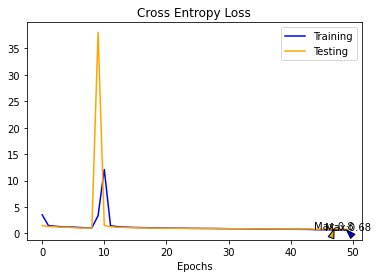

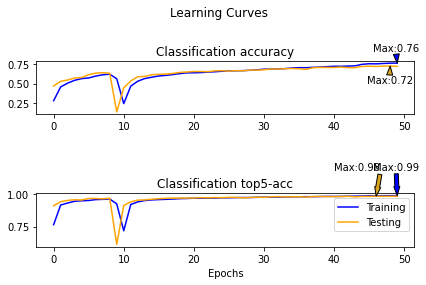

In [ ]:
curves(tested_history)

In [ ]:
with open(path + '/heatmap_kernel_Sg1_32ly_384Dc.pkl','rb') as file:
    tested_heatmap = pickle.load(file)

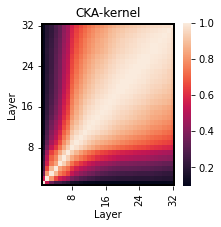

In [ ]:
visualize_Heatmap(tested_heatmap,'kernel',False)

## 1B

In [ ]:
path = 'Results_Article/1B'
total_acc = list()
num_blocks = 8
for i in range(0,num_blocks):
    with open(path + '/accuracy_Blocks_'+ str(num_blocks) + '_L' + str(i+1) +'.pkl','rb') as file:
        partial_acc = pickle.load(file)
        total_acc.append(partial_acc)

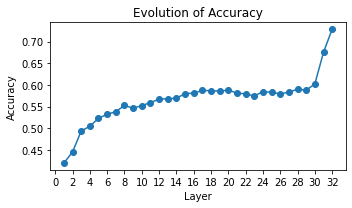

In [ ]:
#Change this parameters
accuracy_evolution_tested = total_acc # the index represents the position of num_blocks
name = '_' + str(num_blocks) +'L' # num_block[1] = 12 (layers)
######################################################
block = len(accuracy_evolution_tested)
x = list(range(1,block+1))
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(x,accuracy_evolution_tested,marker='o')
ax.set_xlabel('Layer')
ax.set_ylabel('Accuracy')
plt.locator_params(axis='x', nbins=block)
plt.title('Evolution of Accuracy')
plt.tight_layout()
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.savefig('Results_Article/1B/EvolutionAcc_' + name +'.png') 
plt.show()
